In [1]:
# import necessary libraries
import pandas as pd
import os
import glob
import datetime as dt
from datetime import datetime 
from matplotlib import pyplot as plt
from math import sqrt
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from statsmodels.tsa.arima.model import ARIMA
#import pandas_datareader as webreader # Remote data access for pandas

import math # Mathematical functions 
import numpy as np # Fundamental package for scientific computing with Python
from numpy import array
import pandas as pd # Additional functions for analysing and manipulating data
import matplotlib.dates as mdates # Formatting dates
from sklearn.metrics import mean_absolute_error, mean_squared_error # Packages for measuring model performance / errors
from tensorflow.keras.models import Sequential # Deep learning library, used for neural networks
from tensorflow.keras.layers import LSTM, Dense, Dropout # Deep learning classes for recurrent and regular densely-connected layers
from tensorflow.keras.callbacks import EarlyStopping # EarlyStopping during model training
from sklearn.preprocessing import RobustScaler, MinMaxScaler # This Scaler removes the median and scales the data according to the quantile range to normalize the price data 
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint, TensorBoard
# Import Libraries and packages from Keras
from tensorflow.keras.optimizers import Adam
plt.style.use('fivethirtyeight')

In [2]:
path = os.getcwd()
txt_files = glob.glob(os.path.join(path, "/Users/dinesh/Documents/Data Science/ASX-2015-2018_orig", "*.txt"))

In [3]:
# use glob to get all the csv files 
# in the folder
path = os.getcwd()
df = pd.DataFrame()
  
# loop over the list of csv files
for f in txt_files:
      
    # read the csv file
    current_df = pd.read_csv(f, header=None)
    #pd.read_csv(io.StringIO(t), names=['Date','AgentName','Group','Direction'], skiprows=1,)
    df = df.append(current_df,ignore_index=True)
      
df.columns = ["Ticker", "Date", "Open", "High", "Low", "Close", "Volume"]
df['Date']=pd.to_datetime(df['Date'], format='%Y%m%d')
df.head()  

,Ticker,Date,Open,High,Low,Close,Volume
0,1AL,2016-01-21,1.030,1.030,1.030,1.030,3000
1,1PG,2016-01-21,3.150,3.150,2.850,3.040,505502
2,3DM,2016-01-21,0.076,0.076,0.075,0.075,59659
3,3PL,2016-01-21,1.430,1.530,1.355,1.520,646143
4,4DS,2016-01-21,0.034,0.034,0.033,0.033,330000


In [13]:
df_table = pd.pivot_table(df, values='Close', index=['Date'], columns=['Ticker'])
df_table.head()

Ticker,1AD,1AG,1AL,1PG,1ST,3DM,3DP,3PL,4CE,4DS,...,ZNO,ZNT,ZNZ,ZOZI,ZRL,ZTA,ZUSD,ZYB,ZYL,ZYUS
Date,,,,,,,,,,,,,,,,,,,,,
2015-01-02,NaN,NaN,NaN,1.215,NaN,NaN,NaN,2.26,NaN,NaN,...,NaN,NaN,NaN,NaN,0.067,NaN,NaN,NaN,NaN,NaN
2015-01-05,NaN,NaN,NaN,1.265,NaN,NaN,NaN,2.07,NaN,NaN,...,NaN,NaN,4.40,NaN,0.070,NaN,NaN,NaN,NaN,NaN
2015-01-06,NaN,NaN,NaN,1.245,NaN,NaN,NaN,2.08,NaN,NaN,...,NaN,NaN,4.39,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-01-07,NaN,NaN,NaN,1.250,NaN,NaN,NaN,2.05,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,0.003,NaN,NaN,NaN,NaN
2015-01-08,NaN,NaN,NaN,1.255,NaN,NaN,NaN,2.08,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# 4.1 Q1. Converting the EOD data into five separate time series data frames; one each for Open, High, Low Close and Volume. In each data frame, rows should be indexed by date, and columns by ticker.

In [4]:
df_open = df.pivot(index='Date', columns='Ticker', values='Open')
df_high = df.pivot(index='Date', columns='Ticker', values='High')
df_low = df.pivot(index='Date', columns='Ticker', values='Low')
df_close = df.pivot(index='Date', columns='Ticker', values='Close')
df_volume = df.pivot(index='Date', columns='Ticker', values='Volume')

# 4.1 Q2. Create a data frame containing the future close returns as defined by Eq. (1), in the same format. Also create a data frame containing close returns.

In [5]:
#Close return according to the equation provided. It can be done in several ways.
#We can use pct_change() function to calculate the close return 
#df_close_returns = df_close.pct_change()
#But I have used a simple calculation
#Close return
df_cr = df_close.div(df_close.shift(1))
df_cr= df_cr-1

#Future close return
df_fcr = df_close.shift(-1).div(df_close)
df_fcr= df_fcr-1

# 4.1 Q3# Create a data frame containing the ratios of High and Low for each ticker each day, in the same format.

In [6]:
df['HL_Ratio'] = df['High']/df['Low']
df_ratio = df.pivot(index='Date', columns='Ticker', values='HL_Ratio')


Ticker,1AD,1AG,1AL,1PG,1ST,3DM,3DP,3PL,4CE,4DS,...,ZNO,ZNT,ZNZ,ZOZI,ZRL,ZTA,ZUSD,ZYB,ZYL,ZYUS
Date,,,,,,,,,,,,,,,,,,,,,
2015-01-02,NaN,NaN,NaN,0.041152,NaN,NaN,NaN,-0.084071,NaN,NaN,...,NaN,NaN,NaN,NaN,0.044776,NaN,NaN,NaN,NaN,NaN
2015-01-05,NaN,NaN,NaN,-0.015810,NaN,NaN,NaN,0.004831,NaN,NaN,...,NaN,NaN,-0.002273,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-01-06,NaN,NaN,NaN,0.004016,NaN,NaN,NaN,-0.014423,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-01-07,NaN,NaN,NaN,0.004000,NaN,NaN,NaN,0.014634,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-01-08,NaN,NaN,NaN,0.015936,NaN,NaN,NaN,0.096154,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# We could fill NaN here but some of the timeseries data stated late hence bigining NaN is not actual NaN, #hence we will handle Nan Individually

#After the data is ready. We go for handling the missing values and stationarity. We can still check seasonality however it has no been applied. If we closely observe data I found out that many values are missing for many tickers. If we dont have enough data, prediction would be really bad. So, I always recommend to go again from more data collection for those specific tickers. In out case, we created a for loop to see the number of missing values in given timestamp. 



There are several methods to handle the missing values, we have used mean imputation to demonstrate the missing value handling.

#Checking weather the data is stationary or not. If we use ARIMA model it can automatically handle non-stationary datas.we check the P value for each column and if P value is > 0.05 we accept the null hypothesis that the timeseries has unit root, i.e, time series is stationary

In [16]:
## lets select tickers that starts on 2015-01-02
## get index of column with first value not NaN

row_1=df_table.iloc[0]
non_nan_col = []
for idx, value in row_1.items():
    if not pd.isnull(value):#include all columns
        non_nan_col.append(str(idx))
df_stat = df_table[non_nan_col]

#Check stationarity

In [17]:


from statsmodels.tsa.stattools import adfuller
arima_models = {}
# We can check for all the tickers. For the demonstration purpose, I have used 21 tickers to check their stationarity
for i in range(0, 20):#df_stat.shape[1]):
    
    # get column name for the ticker
    col_name = df_stat.columns[i]
    #col_name = 'QBE'    
    # get data for the Ticker
    df_model = df[df.Ticker == col_name]
    df_model = df_model[["Date", "Close"]]
    df.sort_values(by=['Date'], inplace=True)
    
    df.dropna(thresh=2, axis=1)
    # if the ticker has less than 6 months of data we exit
    if len(df_model) <180:
        continue
        
    df_model = df_model.set_index("Date")
    
    
    #impute missing value as previous known value 
    df_model = df_model.fillna(method="ffill")

        
    # remove leading and trailing nan from the timeseries and they might be missing due to late indexing of Ticker
    #col_data = col_data.loc[col_data.first_valid_index():col_data.last_valid_index()]
    df_model = df_model.dropna()
     
    
    # check is timeseries is stationary or not
    result = adfuller(df_model["Close"].values, autolag='AIC')
    t_stat, p_value, _, _, critical_values, _  = adfuller(df_model["Close"].values, autolag='AIC')

    print('Ticker {} has p-value of {} and is {}'.format(col_name, p_value, "Non-Stationary" if p_value > 0.05 else "Stationary"))
    
   

Ticker 1PG has p-value of 0.0 and is Stationary
Ticker 3PL has p-value of 0.6376996600344458 and is Non-Stationary
Ticker 8IH has p-value of 0.7630886856014671 and is Non-Stationary
Ticker AAA has p-value of 0.09458643681284085 and is Non-Stationary
Ticker AAC has p-value of 0.4494964443671214 and is Non-Stationary
Ticker AAD has p-value of 0.009011968153376175 and is Stationary
Ticker AAX has p-value of 0.05001816077713417 and is Non-Stationary
Ticker ABC has p-value of 0.6826596433102917 and is Non-Stationary
Ticker ABL has p-value of 0.2679094985100683 and is Non-Stationary
Ticker ABP has p-value of 0.49977452557283625 and is Non-Stationary
Ticker ABU has p-value of 0.18789043616696544 and is Non-Stationary
Ticker ABV has p-value of 0.8818159679014651 and is Non-Stationary
Ticker ABX has p-value of 0.3384243501127042 and is Non-Stationary
Ticker ABY has p-value of 0.9944193853976988 and is Non-Stationary
Ticker ACB has p-value of 0.17209750674271335 and is Non-Stationary
Ticker ACL 

In [ ]:
#There are many tools to handle stationarity. I have not performed because of time constrain.
In the step, I have filled the NAN. I have demonstrated using close value (univariate).

Ticker ADO has p-value of 0.24695417641567735 and is Non-Stationary


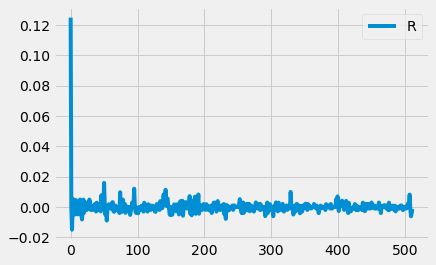

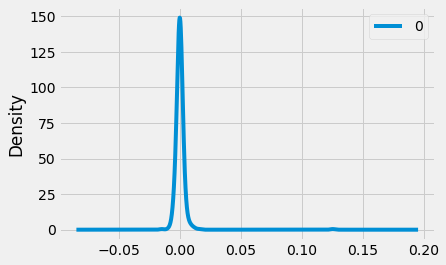

/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximu

Test RMSE: 0.001


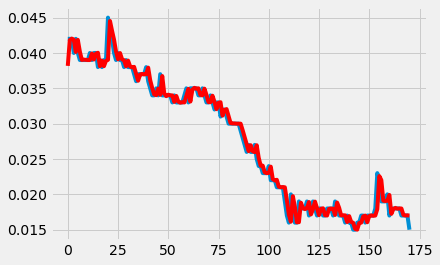

Ticker ADO has p-value of 0.24695417641567735 and is Non-Stationary


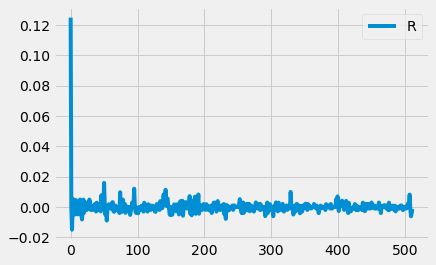

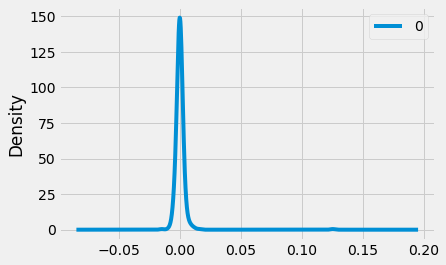

/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximu

Test RMSE: 0.001


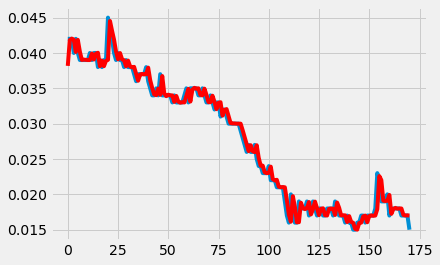

In [18]:
from statsmodels.tsa.stattools import adfuller
# we check the P value for each column and if P value is > 0.05 we accept the null hypothesis that the timeseries has unit root, 
#i.e, time series is stationary
#for i in range(0, df_stat.shape[1]):
arima_models = {}
rnn_models = {}
model_scalar = {}
for i in range(0, 2):#df_stat.shape[1]):
    
    # get column name for the ticker
    #col_name = df_stat.columns[i]
    #col_name = 'QBE'    
    # get data for the Ticker
    df_model = df[df.Ticker == col_name]
    df_model = df_model[["Date", "Close"]]
    df.sort_values(by=['Date'], inplace=True)
    
    # if the ticker has less than 6 months of data we exit
    if len(df_model) < 180:
        continue
        
    df_model = df_model.set_index("Date")
    
    
    #impute missing value as previous known value 
    df_model = df_model.fillna(method="ffill")

        
    # remove leading and trailing nan from the timeseries and they might be missing due to late indexing of Ticker
    #col_data = col_data.loc[col_data.first_valid_index():col_data.last_valid_index()]
    df_model = df_model.dropna()
     
    
    # check is timeseries is stationary or not
    result = adfuller(df_model["Close"].values, autolag='AIC')
    t_stat, p_value, _, _, critical_values, _  = adfuller(df_model["Close"].values, autolag='AIC')

    print('Ticker {} has p-value of {} and is {}'.format(col_name, p_value, "Non-Stationary" if p_value > 0.05 else "Stationary"))
    
        
     #split data in to train, test, validation
    X_train, X_test, y_train, y_test  = train_test_split(df_model["Close"], df_model["Close"], test_size=0.2, shuffle = False, stratify= None)

    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, shuffle = False, stratify= None)
        
    
    #Model Creation
    
    # simple ARIMA model
    # One-Step Out-of-Sample Forecast
    # We can play with this value in arima, parameter tuning can be finding best p q and r for the dataset
    model = ARIMA(X_train.values, order=(3,1,0))     
    model_fit = model.fit()
    # print summary of fit model
    #print(model_fit.summary())
    # line plot of residuals
    residuals = pd.DataFrame(model_fit.resid)
    residuals.plot()
    plt.legend('Residual Plot')
    plt.show()
    # density plot of residuals
    residuals.plot(kind='kde')
    plt.show()

    # store model for ticker
    arima_models[col_name] = model_fit
    
    predictions = list()
    test = X_val.values
    history =[x for x in X_train.values] 
    # walk-forward validation
    for t in range(len(test)):
        model = ARIMA(history, order=(3,1,0))
        model_fit = model.fit()
        output = model_fit.forecast()
        yhat = output[0]
        predictions.append(yhat)
        obs = test[t]
        history.append(obs)

    
    # evaluate forecasts
    rmse = sqrt(mean_squared_error(test, predictions))
    print('Test RMSE: %.3f' % rmse)
    # plot forecasts against actual outcomes
    plt.plot(test)
    plt.plot(predictions, color='red')
    plt.show()

# LSTM implementation for prediction

#For the demonstration purpose, I have used one value 'Close' from a Ticker. We can create many features as shown below. We need to do a feature engineering to find the usefull features for this prediction. These features can be feed to the neural network. As per the question, we should have choosen future close return. However, I have demonstrated using close. All the developed features can be feed into neural network using multivariate analysis which examines two or more variables. I have demonstrated multivariate LSTM model implementation and prediction in the aonther source code.

In [19]:
#Feature Engineering
#Create features
df_model["last_week_average"] = df_model["Close"].rolling(7).mean()
df_model["last_week_max"] = df_model["Close"].rolling(7).max()
df_model["last_week_min"] = df_model["Close"].rolling(7).min()
#df_model["cr"] = df_model["Close"].diff(periods=1)
df_model["t1"] = df_model["Close"].shift(1)
df_model["t2"] = df_model["Close"].shift(2)
df_model["t3"] = df_model["Close"].shift(3)
df_model["t4"] = df_model["Close"].shift(4)
df_model["t5"] = df_model["Close"].shift(5)
df_model["t6"] = df_model["Close"].shift(6)
df_model["t7"] = df_model["Close"].shift(7)
df_model["t8"] = df_model["Close"].shift(8)
df_model["t9"] = df_model["Close"].shift(9)
df_model["t10"] = df_model["Close"].shift(10)
#df_model["fcr"]= df_model["Close"].pct_change(fill_method ='ffill')
#Close return
df_model["cr"] = df_model["Close"].div(df_model["Close"].shift(1))
df_model["cr"]= df_model["cr"]-1

#Future close return
df_model["fcr"] = df_model["Close"].shift(-1).div(df_model["Close"])
df_model["fcr"]= df_model["fcr"]-1
df_model["last_week_day_change"] = df_model["cr"].shift(7)

#df_model.reset_index(inplace=True)
df_model = df_model.dropna()



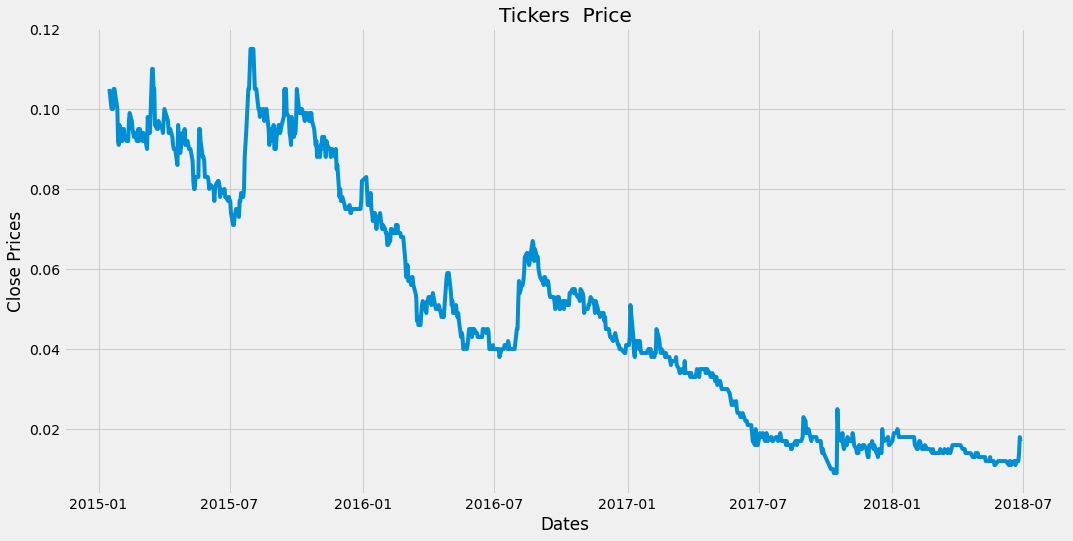

In [21]:
#Visualize the per day closing price of the stock.
#plot close price
plt.figure(figsize=(16,8))
plt.grid(True)
plt.xlabel('Dates')
plt.ylabel('Close Prices')
plt.plot(df_model['Close'])
plt.title('Tickers  Price')
plt.show()

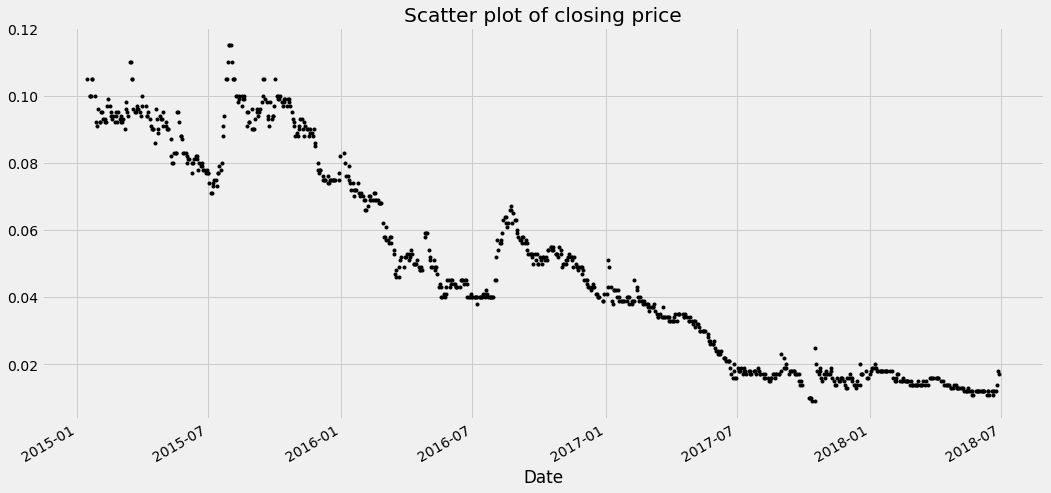

In [22]:
#Lets us plot the scatterplot:
plt.figure(figsize=(16,8))
df_close = df_model['Close']
df_close.plot(style='k.')
plt.title('Scatter plot of closing price')
plt.show()

In [23]:
#create a new dataframe with only 'Close Column'
data = df_model.filter(['Close'])
#convert the dataframe to a numpy array
dataset = data.values
#get the number of rows to train the model on

training_data_len = math.ceil(len(dataset)*.8)
training_data_len

675

In [24]:
#scale the data : WE need to scale before we input to the neural network
scaler  = MinMaxScaler(feature_range= (0,1))
scaled_data = scaler.fit_transform(dataset)

scaled_data.shape

(843, 1)

In [25]:
train_data = scaled_data[0:training_data_len, :]
len(train_data)

675

In [26]:
#create the trainning data set
#create the scalled trainning data set

train_data = scaled_data[0:training_data_len, :]

#split the data into x_train and y_train data sets

x_train = []
y_train = [] #target variable

for i in range(120, len(train_data)):
    x_train.append(train_data[i-120:i,0])
    y_train.append(train_data[i,0])
    if i<= 120:
        print(x_train)
        print(y_train)
        print()

[array([0.90566038, 0.85849057, 0.85849057, 0.85849057, 0.90566038,
       0.90566038, 0.85849057, 0.78301887, 0.77358491, 0.82075472,
       0.78301887, 0.78301887, 0.81132075, 0.81132075, 0.79245283,
       0.78301887, 0.79245283, 0.78301887, 0.83018868, 0.8490566 ,
       0.83018868, 0.81132075, 0.80188679, 0.79245283, 0.80188679,
       0.78301887, 0.80188679, 0.81132075, 0.78301887, 0.81132075,
       0.79245283, 0.78301887, 0.80188679, 0.78301887, 0.79245283,
       0.76415094, 0.83962264, 0.82075472, 0.81132075, 0.80188679,
       0.95283019, 0.95283019, 0.90566038, 0.90566038, 0.82075472,
       0.81132075, 0.81132075, 0.83018868, 0.82075472, 0.82075472,
       0.81132075, 0.80188679, 0.83018868, 0.85849057, 0.83018868,
       0.80188679, 0.80188679, 0.81132075, 0.79245283, 0.77358491,
       0.76415094, 0.76415094, 0.76415094, 0.72641509, 0.82075472,
       0.79245283, 0.76415094, 0.75471698, 0.80188679, 0.79245283,
       0.79245283, 0.81132075, 0.77358491, 0.78301887, 0.7735

In [27]:
#convert the x_train and y_train to numpy arrays
x_train, y_train = np.array(x_train),np.array(y_train)

print('x_train shape == {}.'.format(x_train.shape))
print('y_train shape == {}.'.format(y_train.shape))

x_train shape == (555, 120).
y_train shape == (555,).


In [28]:
#Reshape the data 
#Why reshape is important : LSTM network expects the input to be 3 dimensional in 
#the form of the number sample, number of time stamps and number of features. 
#In our case our X_train data is two dimensional
x_train = np.reshape(x_train,(x_train.shape[0],x_train.shape[1], 1))
x_train.shape


(555, 120, 1)

In [29]:
#Build the LSTM model
model  =Sequential()
model.add(LSTM(50,return_sequences = True, input_shape = (x_train.shape[1],1)))
model.add(LSTM(50,return_sequences = False))
model.add(Dense(25))
model.add(Dense(1))

In [30]:
#Comppile the model
model.compile(optimizer='adam', loss = 'mean_squared_error')

In [31]:
#train the model
model.fit(x_train, y_train, batch_size=1, epochs=1)

555/555 [==============================] - 32s 52ms/step - loss: 0.0050


In [32]:
#create the testing dataset
#create the new array containging scaled value from index

test_data = scaled_data[training_data_len-120:,:]
#create the datasets x_test, y_test
x_test = []
y_test  =dataset[training_data_len:,:] #all of the value that we want our value
for i in range(120, len(test_data)):
    x_test.append(test_data[i-120:i, 0])

In [33]:
# convert the data to a numpy array
x_test = np.array(x_test)

In [34]:
#Reshape the data
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

In [35]:
x_test.shape

(168, 120, 1)

In [36]:
#Get the model predicted price values
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)

In [37]:
#Evaluate our model
#Get the RMSE  ( root mean square error)
rmse = np.sqrt(np.mean(predictions - y_test)**2)
rmse

6.721099168949176e-05

<ipython-input-38-58085c87dcf3>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Predictions'] = predictions


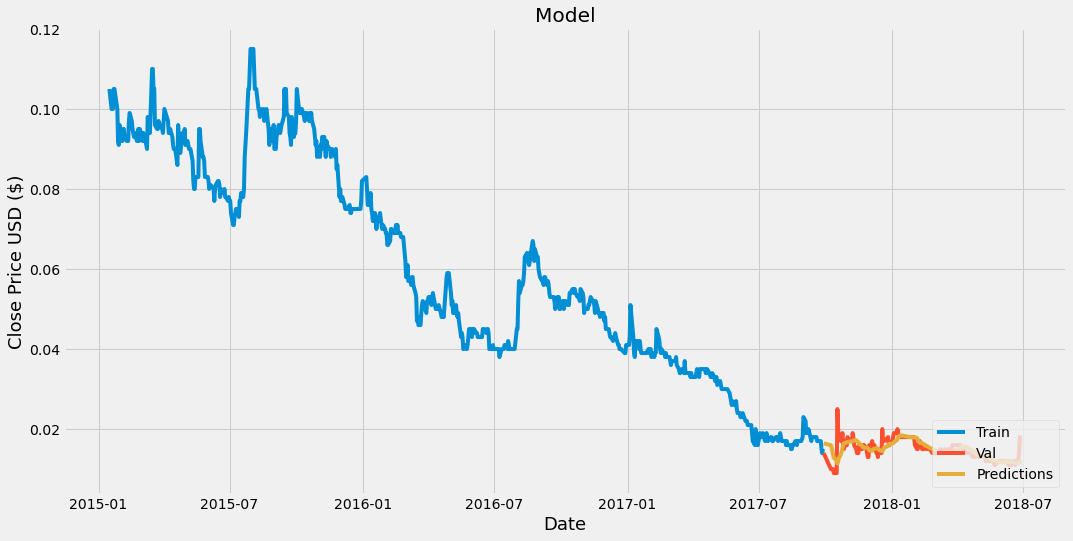

In [38]:
#plot the data
train = data[:training_data_len]
valid = data[training_data_len:]
valid['Predictions'] = predictions
#Visualize the data
plt.figure(figsize=(16,8))
plt.title('Model')
plt.xlabel('Date', fontsize = 18)
plt.ylabel('Close Price USD ($)', fontsize = 18)
plt.plot(train['Close'])
plt.plot(valid[['Close','Predictions']])
plt.legend(['Train', 'Val', 'Predictions'], loc = 'lower right')
plt.show()

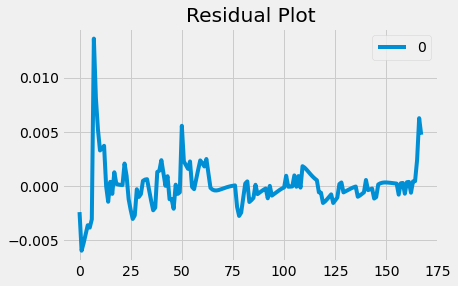

In [39]:
# calculate residuals
residuals = [y_test[i]-predictions[i] for i in range(len(predictions))]
residuals = pd.DataFrame(residuals)
# plot residuals
residuals.plot()
plt.title('Residual Plot')
plt.show()

# Please note that this project was created just for the demonstration purpose in the short interval of time. We can further improvise and train the model again. Hyperparameters can be tuned according to the requirement.


For the model evaluation a rolling-forecast scenario can also be used. In the evaluation model, each time step of the test dataset will be walked one at a time. A model will be used to make a forecast for the time step, then the actual expected value from the test set will be taken and made available to the model for the forecast on the next time step.